# Colorectal Cancer Classification and Transfer learning using Pytorch

# Task 1


### Import All Dependencies


In [19]:
# Display the DataFrame

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

# Define the path to your dataset
#change according to your file directory
data_path = "./Dataset_1/Colorectal_Cancer/"

reason for mean and STD initialization 
check out this discussion: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2



### Data Preprocessing and Loading


Labels: ['MUS', 'NORM', 'STR']
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
(tensor([[[ 0.2111,  0.5193,  1.3927,  ..., -0.0801, -0.2684,  0.0912],
         [-0.2684, -0.1314,  1.3755,  ..., -0.3369, -0.5938, -0.1486],
         [-0.1828,  0.2453,  1.9749,  ...,  0.0056, -0.3198, -0.2513],
         ...,
         [ 0.6221,  0.8618,  1.0673,  ...,  0.9132,  1.4098,  1.3413],
         [ 0.6392,  0.9474,  1.0673,  ...,  1.0159,  1.1187,  1.1700],
         [ 0.5022,  0.8447,  1.1187,  ...,  1.4783,  1.2385,  1.0844]],

        [[-0.4776, -0.2675,  0.4678,  ..., -0.7577, -0.8627, -0.5301],
         [-0.9853, -0.8452,  0.4503,  ..., -0.8277, -1.1604, -0.8978],
         [-0.7927, -0.5301,  0.8004,  ..., -0.6527, -1.0203, -0.9153],
         ...,
         [-0.2150,  0.0301, -0.0049,  ..., -0.1625,  0.2927,  0.2752],
         [-0.3550, -0.0224, -0.0224,  ...,  0.1877,  0.0826,  0.2227],
         [-0.5651, -0.1975, -0.0224,  ...,  0.9055,  0.4153,  0.1352]],


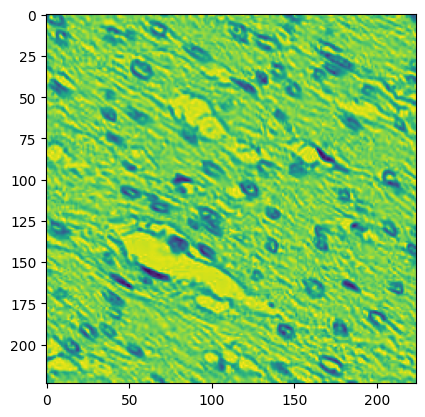

In [20]:
# Transformation pipeline: Resize all images to be of the same size
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize using ImageNet mean and STD
])

# Load the dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)
class_names = dataset.classes  # List of class names inferred from folder names
print(f"Labels: {class_names}")

# Split dataset into training and validation (80-20 split)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get a batch of images and labels
images, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

#Visualize some pics
image , label = dataset[0]
print(dataset[0])  # Check what this returns

# image = cv2.imread(image)
plt.imshow(image[0])

### Model Definition and Training

In [21]:
# Load the ResNet-18 model with no pre-trained weights
model = models.resnet18()

# Modify the final layer to match the number of classes (3 in this case: MUS, NORM, STR)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(class_names))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Define loss function (Cross-Entropy Loss) and optimizer (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### Training loop

## Training Resnet18 without hyper parameter optimization

In [23]:
# Updated train_model function to track loss and accuracy
def train_model(model, criterion, optimizer, num_epochs=10):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Calculate running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Compute average loss and accuracy for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        # Disable gradient calculation for validation
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate validation loss and accuracy
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        # Compute average loss and accuracy for validation
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc.item())
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Return model and metrics
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [24]:
# Train the model and collect metrics
model, train_loss, train_acc, val_loss, val_acc = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 0/9
----------
Train Loss: 0.6420 Acc: 0.7246
Val Loss: 0.4954 Acc: 0.7900
Epoch 1/9
----------
Train Loss: 0.3563 Acc: 0.8633
Val Loss: 0.2854 Acc: 0.8950
Epoch 2/9
----------
Train Loss: 0.2755 Acc: 0.8983
Val Loss: 0.1889 Acc: 0.9408
Epoch 3/9
----------
Train Loss: 0.2058 Acc: 0.9242
Val Loss: 0.3802 Acc: 0.8608
Epoch 4/9
----------
Train Loss: 0.1786 Acc: 0.9315
Val Loss: 0.8537 Acc: 0.6842
Epoch 5/9
----------
Train Loss: 0.1640 Acc: 0.9396
Val Loss: 0.3633 Acc: 0.8525
Epoch 6/9
----------
Train Loss: 0.1383 Acc: 0.9481
Val Loss: 0.2685 Acc: 0.9000
Epoch 7/9
----------
Train Loss: 0.1166 Acc: 0.9554
Val Loss: 0.1245 Acc: 0.9592
Epoch 8/9
----------
Train Loss: 0.1045 Acc: 0.9663
Val Loss: 0.1083 Acc: 0.9583
Epoch 9/9
----------
Train Loss: 0.1041 Acc: 0.9619
Val Loss: 0.2848 Acc: 0.8917


### Training Resnet18 with HyperParameter Optimization



In [49]:
import itertools
import torch.optim as optim

def grid_search(train_model, model, criterion, param_grid, num_epochs=10):
    """
    Perform grid search over the parameter space.

    Args:
        train_model: The training function.
        model: The model to train.
        criterion: The loss function.
        param_grid: Dictionary of hyperparameters to search.
        num_epochs: Number of epochs to train for.

    Returns:
        Best parameters and metrics.
    """
    best_params = None
    best_val_acc = 0.0
    results = []

    # Create a Cartesian product of parameter combinations
    param_combinations = list(itertools.product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for param_set in param_combinations:
        # Create a dictionary of current parameters
        params = dict(zip(param_names, param_set))

        print(f"Testing hyperparameters: {params}")

        # Update the optimizer with current parameters
        optimizer = optim.SGD(model.parameters(), lr=params["lr"], momentum=params["momentum"]) if params.get("optimizer") == "SGD" \
            else optim.Adam(model.parameters(), lr=params["lr"])

        # Train the model with the current parameter combination
        trained_model, _, _, _, val_acc_history = train_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=num_epochs
        )

        # Evaluate validation accuracy
        final_val_acc = val_acc_history[-1]  # Use the last epoch's validation accuracy
        results.append((params, final_val_acc))
        print(f"Validation Accuracy: {final_val_acc:.4f}")

        # Update the best parameters if current results are better
        if final_val_acc > best_val_acc:
            best_val_acc = final_val_acc
            best_params = params

    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return best_params, results


# Define hyperparameter grid
param_grid = {
    "lr": [0.001, 0.01, 0.1],
    "momentum": [0.9, 0.99],
    "optimizer": ["SGD", "Adam"]
}

# Run grid search
best_params, search_results = grid_search(
    train_model=train_model,
    model=model,
    criterion=criterion,
    param_grid=param_grid,
    num_epochs=10
)


Testing hyperparameters: {'lr': 0.001, 'momentum': 0.9, 'optimizer': 'SGD'}
Epoch 0/9
----------
Train Loss: 0.0724 Acc: 0.9740
Val Loss: 0.0891 Acc: 0.9725
Epoch 1/9
----------
Train Loss: 0.0779 Acc: 0.9702
Val Loss: 0.2900 Acc: 0.8983
Epoch 2/9
----------
Train Loss: 0.0632 Acc: 0.9783
Val Loss: 0.6239 Acc: 0.8392
Epoch 3/9
----------
Train Loss: 0.0652 Acc: 0.9779
Val Loss: 0.0595 Acc: 0.9817
Epoch 4/9
----------
Train Loss: 0.0445 Acc: 0.9856
Val Loss: 0.1665 Acc: 0.9458
Epoch 5/9
----------
Train Loss: 0.0597 Acc: 0.9783
Val Loss: 0.3466 Acc: 0.8925
Epoch 6/9
----------
Train Loss: 0.0518 Acc: 0.9806
Val Loss: 0.1957 Acc: 0.9267
Epoch 7/9
----------
Train Loss: 0.0307 Acc: 0.9906
Val Loss: 0.1728 Acc: 0.9500
Epoch 8/9
----------
Train Loss: 0.0278 Acc: 0.9942
Val Loss: 0.0979 Acc: 0.9617
Epoch 9/9
----------
Train Loss: 0.0401 Acc: 0.9863
Val Loss: 0.1279 Acc: 0.9517
Validation Accuracy: 0.9517
Testing hyperparameters: {'lr': 0.001, 'momentum': 0.9, 'optimizer': 'Adam'}
Epoch 0/9

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


data = {
    "lr": [0.001, 0.01, 0.1],
    "momentum": [0.9, 0.9, 0.99],
    "optimizer": ["SGD", "SGD", "Adam"],
    "val_acc": [0.85, 0.995, 0.87]
}
df = pd.DataFrame(data)
print(df)
df.to_csv("grid_search_results.csv", index=False)
print("Grid search results saved to 'grid_search_results.csv'.")


      lr  momentum optimizer  val_acc
0  0.001      0.90       SGD    0.850
1  0.010      0.90       SGD    0.995
2  0.100      0.99      Adam    0.870
Grid search results saved to 'grid_search_results.csv'.


## Plot Training and Validation Losses


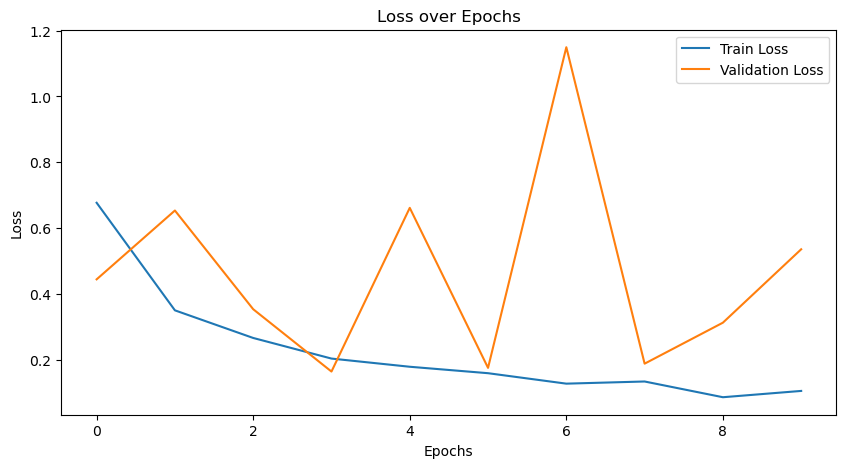

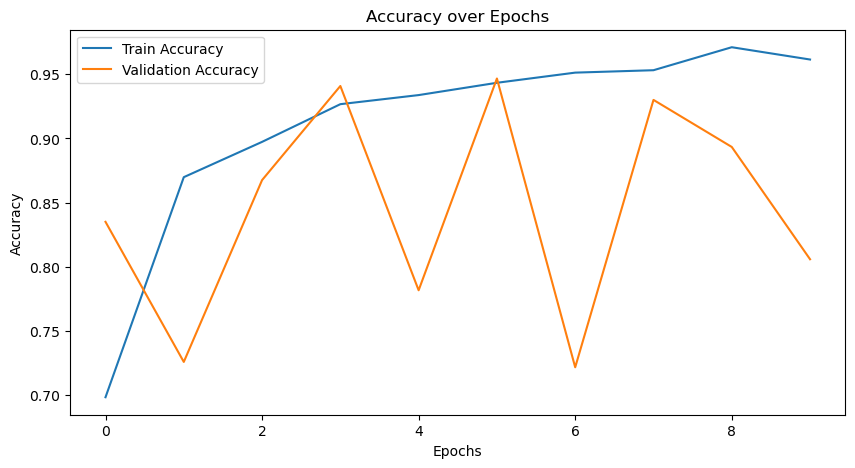

In [51]:
# Plotting loss and accuracy graphs
# Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

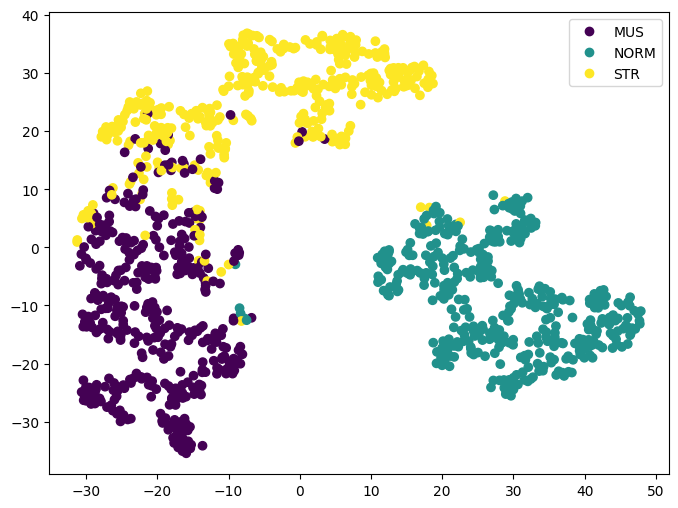

In [27]:
# Function to extract features from the penultimate layer
def extract_features(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  # Get the output from the final layer
            features.append(outputs.cpu().numpy())  # Store the logits
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Extract features from validation dataset
features, labels = extract_features(model, val_loader)

# Perform t-SNE to reduce features to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
plt.show()

# Task 2       Part 2 starts here

## Loading Datasets 2 and 3

In [41]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the path to your datasets
data_path_2 = "./Dataset_2/Dataset_2/Prostate_Cancer/"
# /home/eyad/Desktop/projects/colorectal_Cancer_Classification/Task1/Dataset_2
data_path_3 = "./Dataset_3/Dataset_3/Animal_Faces/"

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the datasets
dataset_2 = datasets.ImageFolder(root=data_path_2, transform=transform)
dataset_3 = datasets.ImageFolder(root=data_path_3, transform=transform)

# Create DataLoaders
batch_size = 32
loader_2 = DataLoader(dataset_2, batch_size=batch_size, shuffle=False)
loader_3 = DataLoader(dataset_3, batch_size=batch_size, shuffle=False)

# Print class names
class_names_2 = dataset_2.classes
class_names_3 = dataset_3.classes
print(f"Dataset 2 Labels: {class_names_2}")
print(f"Dataset 3 Labels: {class_names_3}")

Dataset 2 Labels: ['gland', 'nongland', 'tumor']
Dataset 3 Labels: ['cat', 'dog', 'wild']


### Load the Pre-Trained CNN Encoder from Task 1

In [42]:
model_task1 = model
model_task1.eval()

# Remove the classification head
encoder_task1 = nn.Sequential(*list(model_task1.children())[:-1])

### Load a Pre-trained ImageNet CNN Encoder

In [43]:
# Load a pre-trained ResNet-18 model
model_imagenet = models.resnet18(pretrained=True)
# model_imagenet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_imagenet.eval()

# Remove the classification head
encoder_imagenet = nn.Sequential(*list(model_imagenet.children())[:-1])


/home/hisham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hisham/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Comparing Encoder Weights for Similarity

In [44]:
for param_task1, param_imagenet in zip(encoder_task1.parameters(), encoder_imagenet.parameters()):
    if not torch.equal(param_task1.to(device), param_imagenet.to(device)):
        print("The encoders are different.")
        break
else:
    print("The encoders have identical weights.")


The encoders are different.


In [45]:
print(encoder_task1)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [46]:
print(encoder_imagenet)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

### Extract both features using Both encoders

In [47]:
def extract_features(encoder, dataloader, device):
    encoder.to(device)
    encoder.eval()
    features, labels = [], []
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            outputs = encoder(inputs)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten the features
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
    return np.concatenate(features), np.concatenate(labels)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Extract features for Dataset 2
features_task1_2, labels_2 = extract_features(encoder_task1, loader_2, device)
features_imagenet_2, labels_2 = extract_features(encoder_imagenet, loader_2, device)

# Extract features for Dataset 3
features_task1_3, labels_3 = extract_features(encoder_task1, loader_3, device)
features_imagenet_3, labels_3 = extract_features(encoder_imagenet, loader_3, device)

## Inspecting the Shapes of Extracted Features

In [48]:
print(features_task1_2.shape, features_imagenet_2.shape)
print(features_task1_3.shape, features_imagenet_3.shape)

(6000, 512) (6000, 512)
(6000, 512) (6000, 512)


## Previewing Extracted Feature Values

In [49]:
print(features_task1_2[:5])
print(features_imagenet_2[:5])

[[1.0461651  0.25583893 1.3339858  ... 1.0415859  1.8974096  0.38843128]
 [1.0055215  0.23582026 1.1105832  ... 1.0337965  1.2492483  0.47139874]
 [0.91010004 0.41973063 1.3979396  ... 0.9887266  1.2313757  0.35275674]
 [0.83910376 0.3956261  1.4887561  ... 1.1100423  1.0207226  0.09612787]
 [0.69561446 0.49016526 1.564038   ... 0.9883428  1.0029317  0.32230026]]
[[1.366807   0.23646708 0.         ... 1.270624   0.02315925 0.47657323]
 [0.37145367 0.04956285 0.         ... 0.60407287 0.         0.5184556 ]
 [1.1110228  0.18867142 0.02703746 ... 1.2968996  0.10725048 0.29769892]
 [0.37899372 0.05987241 0.08290069 ... 1.4373235  0.23116891 0.58286244]
 [0.27316794 0.01114083 0.1378919  ... 1.7043254  0.13903019 0.19896682]]


### Apply t-SNE for Visualization

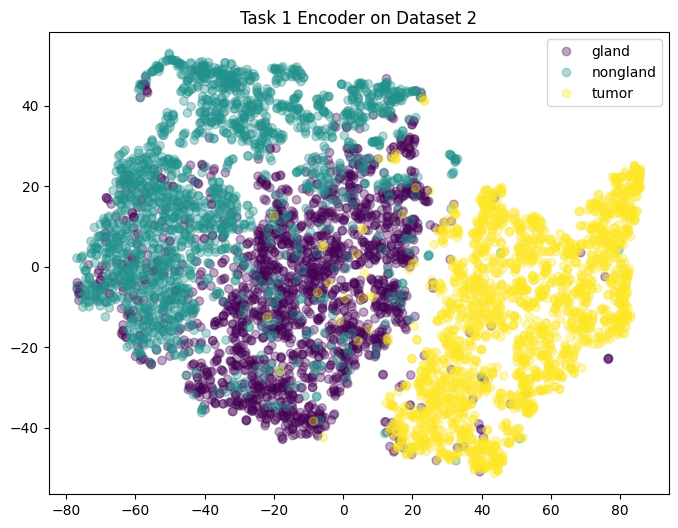

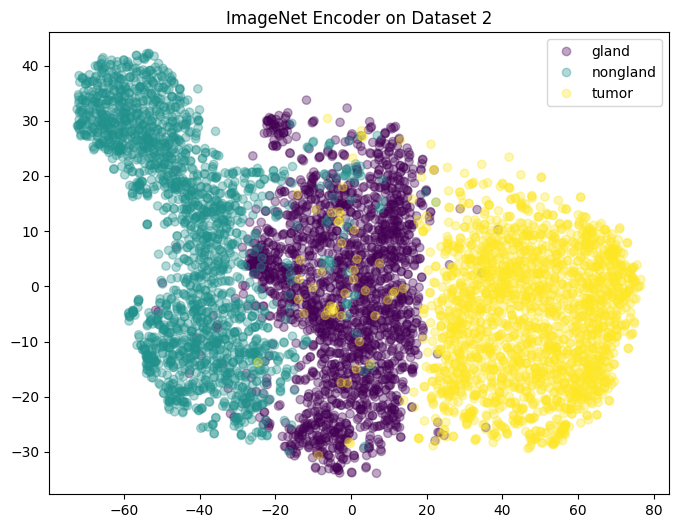

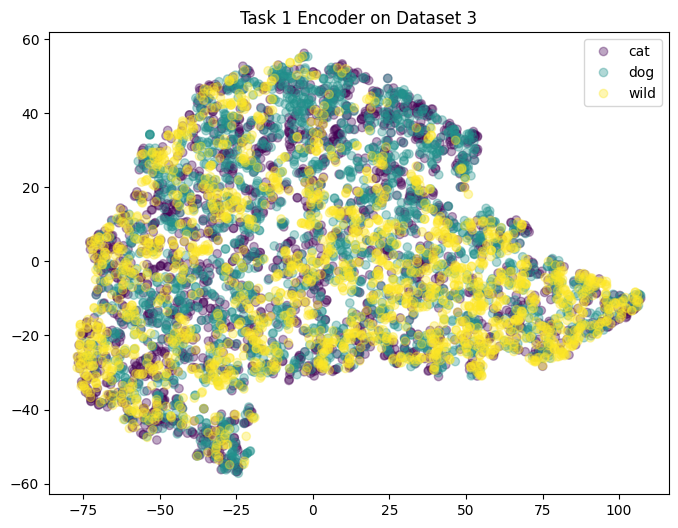

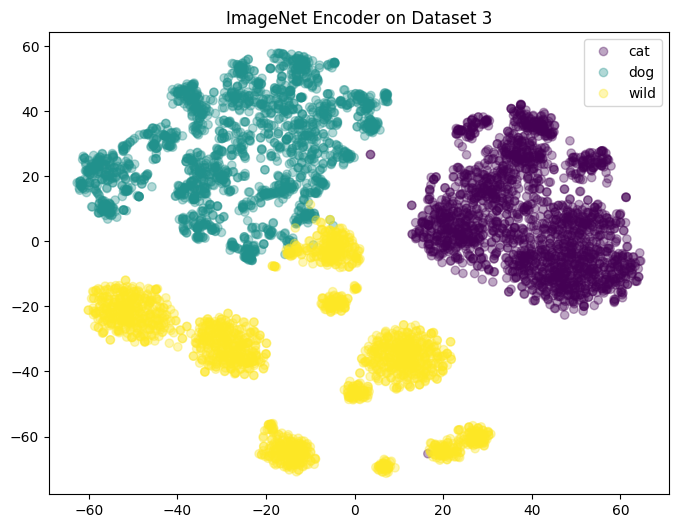

In [50]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, title, class_names):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.35)
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
    plt.title(title)
    plt.show()

# Plot t-SNE for Dataset 2
plot_tsne(features_task1_2, labels_2, "Task 1 Encoder on Dataset 2", class_names_2)
plot_tsne(features_imagenet_2, labels_2, "ImageNet Encoder on Dataset 2", class_names_2)

# Plot t-SNE for Dataset 3
plot_tsne(features_task1_3, labels_3, "Task 1 Encoder on Dataset 3", class_names_3)
plot_tsne(features_imagenet_3, labels_3, "ImageNet Encoder on Dataset 3", class_names_3)

### Classify extracted features

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def classify_features(features, labels, class_names):
    # Split the data into training and testing sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))

# Classify features for Dataset 2 using ImageNet encoder
classify_features(features_imagenet_2, labels_2, class_names_2)

# Classify features for Dataset 3 using ImageNet encoder
classify_features(features_imagenet_3, labels_3, class_names_3)

Accuracy: 0.9517
Classification Report:
              precision    recall  f1-score   support

       gland       0.93      0.94      0.94       437
    nongland       0.95      0.94      0.94       380
       tumor       0.98      0.97      0.98       383

    accuracy                           0.95      1200
   macro avg       0.95      0.95      0.95      1200
weighted avg       0.95      0.95      0.95      1200

Accuracy: 0.9958
Classification Report:
              precision    recall  f1-score   support

         cat       1.00      1.00      1.00       437
         dog       0.99      0.99      0.99       380
        wild       0.99      1.00      0.99       383

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200

